# Strain mapping of experimental h-BN using corerlation 

This notebook measures the strain fields of a experiemental 4D-STEM dataset which consists of hBN samples at different probe size, using correlation based approach implemented in py4dstem module.

[Download the experimental boronnitride (hBN)](https://drive.google.com/drive/folders/1oc7wYMUETNiZOASQ8Hu0TwNyZezsr5Yj)

### Acknowledgements

This tutorial was written by Joydeep Munshi (jmunshi@anl.gov) at Argonne National Lab and Colin Ophus (clophus@lbl.gov) at Berkeley Lab.

The experiments are performed by Jim Ciston (jciston@lbl.gov) at Berkeley Lab.

### Version
Last updated on 2022-01-21 with py4DSTEM version 0.12.8 and crystal4D version 0.1.7.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
#Download the required database directly from google drive
from py4DSTEM.io import download_file_from_google_drive
#Change the 2nd argument of the function according to location of your local drive
download_file_from_google_drive("18FIzhBJKGaoMuIU0zPPY3nyVJrTBRC_m", "./hBN_3.4mrad.h5")
#download_file_from_google_drive("19W0iUK8B1PYYZPhlIb7iIV69TFJAktsJ", "./hBN_3.4mrad_BE.h5")
#download_file_from_google_drive("1rMEQ_JUk0kCBNMph7Va2VCdcel6mRvWP", "./hBN_0.86mrad.h5")
#download_file_from_google_drive("17vlwxj62yj5d4Sw7n7i5tLue8o9Pujov", "./hBN_12mrad.h5")

In [2]:
#import required python libraries

import os
import h5py
import copy
import py4DSTEM
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

In [3]:
# File paths - output files will be augmented with the correct file extension
file_path_input_cbed = "./hBN_3.4mrad.h5"
#file_path_input_cbed = "./hBN_3.4mrad_BE.h5"
#file_path_input_cbed = "./hBN_0.86mrad.h5"
#file_path_input_cbed = "./hBN_12mrad.h5"
file_path_output = './hBN_3.4mrad_strain_corr.h5'
#file_path_output = "./hBN_3.4mrad_BE_strain_corr.h5"
#file_path_output = "./hBN_0.86mrad_strain_corr.h5"
#file_path_output = "./hBN_12mrad_strain_corr.h5"

In [4]:
#Load the datacubes using py4DSTEM
dataset_probe = py4DSTEM.io.read(file_path_input_cbed, data_id='probe_kernel_crop')
dataset_cbed = py4DSTEM.io.read(file_path_input_cbed, data_id='datacube_0')

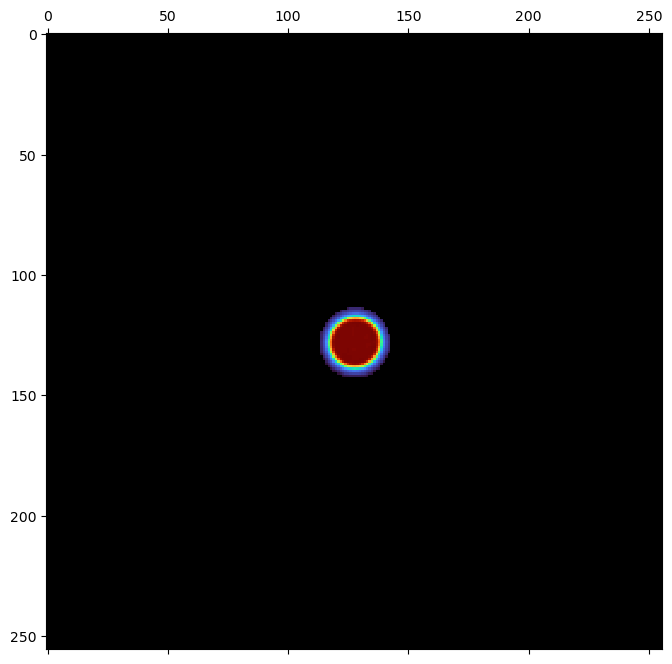

In [5]:
#Generate the mean probe
probe_mean = dataset_probe.data

# Plot the mean Probe
py4DSTEM.visualize.show(
    probe_mean,
    scaling = 'power',
    power = 0.5,
    cmap='turbo')

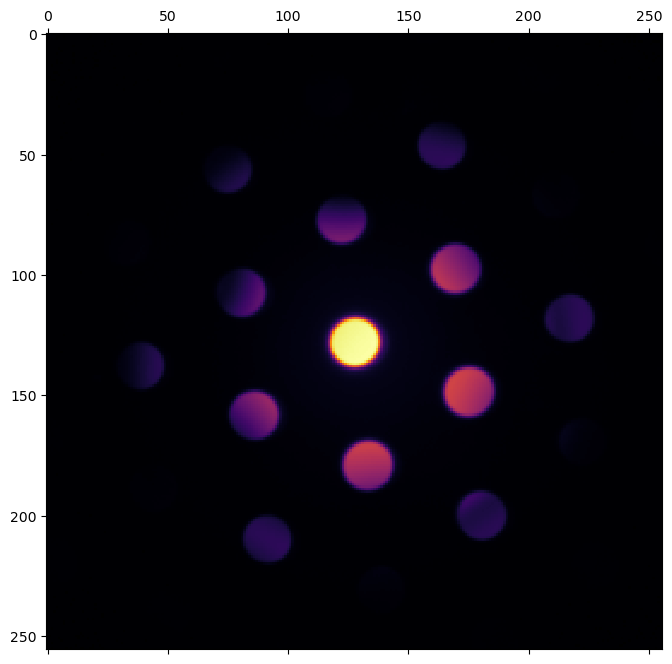

In [6]:
# Plot the mean diffraction
diffraction_pattern_mean = np.mean(dataset_cbed.data, axis=(0,1))
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    scaling='power',
    power = 0.5,
    cmap='inferno')

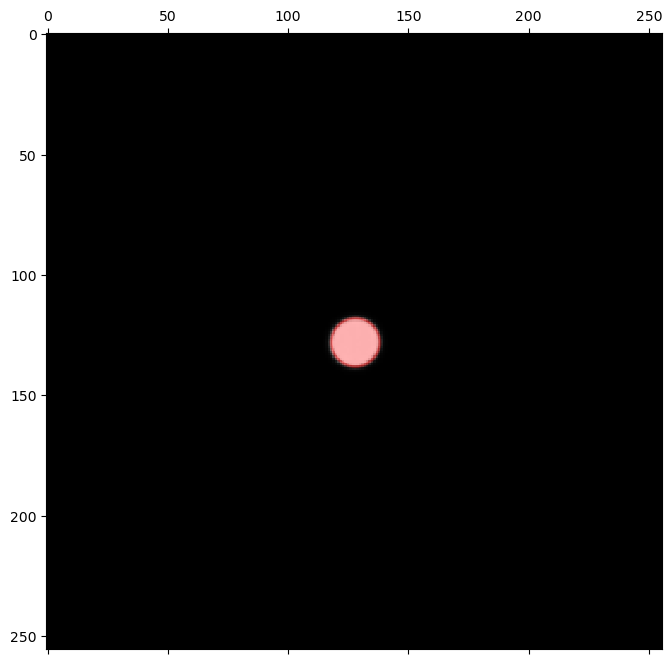

Estimated probe radius = 10.16 pixels
127.96441357696183 127.9782652410498


In [7]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(
    probe_mean,
    thresh_lower = 0.01,
    thresh_upper = 0.85)

#qx0, qy0 = np.argmax(diffraction_pattern_mean)//256,np.argmax(diffraction_pattern_mean)%256

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    probe_mean, 
    (qx0, qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')
print(qx0, qy0)

# Virtual image

In [8]:
# Next, create a BF virtual detector using the the center beam position (qxy0, qy0), and a virtual DF detector.
# The DF virtual detector can be set to all remaining pixels.
expand_BF = 4.0
image_BF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset_cbed, 
    qx0, qy0, 
    probe_semiangle + expand_BF)
image_DF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset_cbed, 
    qx0, qy0, 
    probe_semiangle + expand_BF,
    1e3)

100%|██████████| 12096/12096 [00:00<00:00, 13559.96it/s]


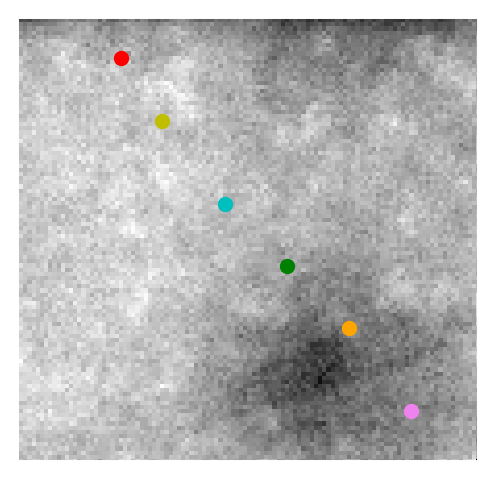

In [9]:
rxs = 10, 25, 45, 60, 75, 95,
rys = 25, 35, 50, 65, 80, 95

fig, ax = py4DSTEM.visualize.show(image_BF,
                                  figsize=(6,6),
                                  bordercolor = 'w',
                                  cmap='gray',
                                  returnfig = True)
ax.scatter(rys[0], rxs[0], c='r', s=100)
ax.scatter(rys[1], rxs[1] , c='y', s=100)
ax.scatter(rys[2], rxs[2], c='c', s=100)
ax.scatter(rys[3], rxs[3], c='g', s=100)
ax.scatter(rys[4], rxs[4], c='orange', s=100)
ax.scatter(rys[5], rxs[5], c='violet', s=100)
#fig.savefig('./paper_figs/experiment_thick_BF.pdf', dpi=600)
plt.show()

# correlation

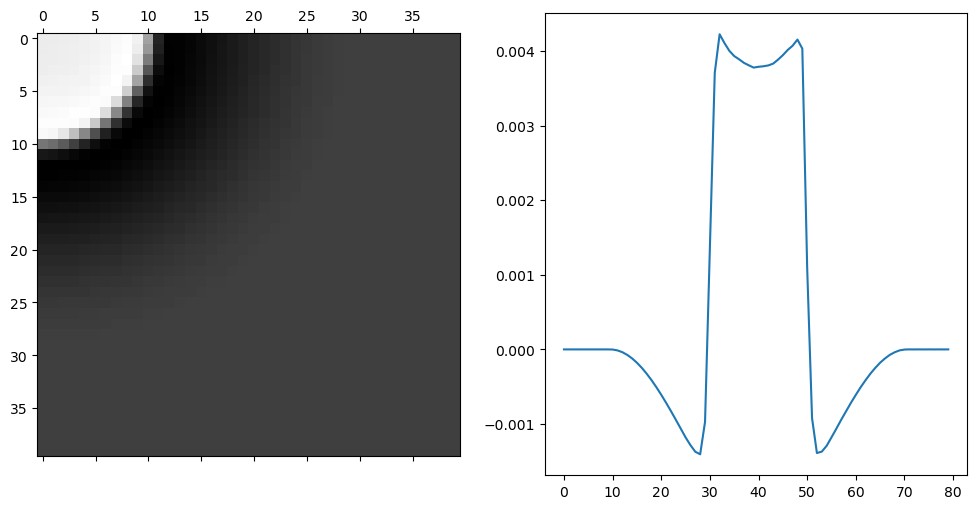

In [10]:
# Construct a probe template - we already have the probe array imported, so we start there.

# Shift probe to the origin and apply normalization by subtracting a sigmoid function.
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(
    probe_mean.data, 
    probe_semiangle * 0.0,                                            
    probe_semiangle * 3.0,)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=40, 
    L=40, 
    W=2)

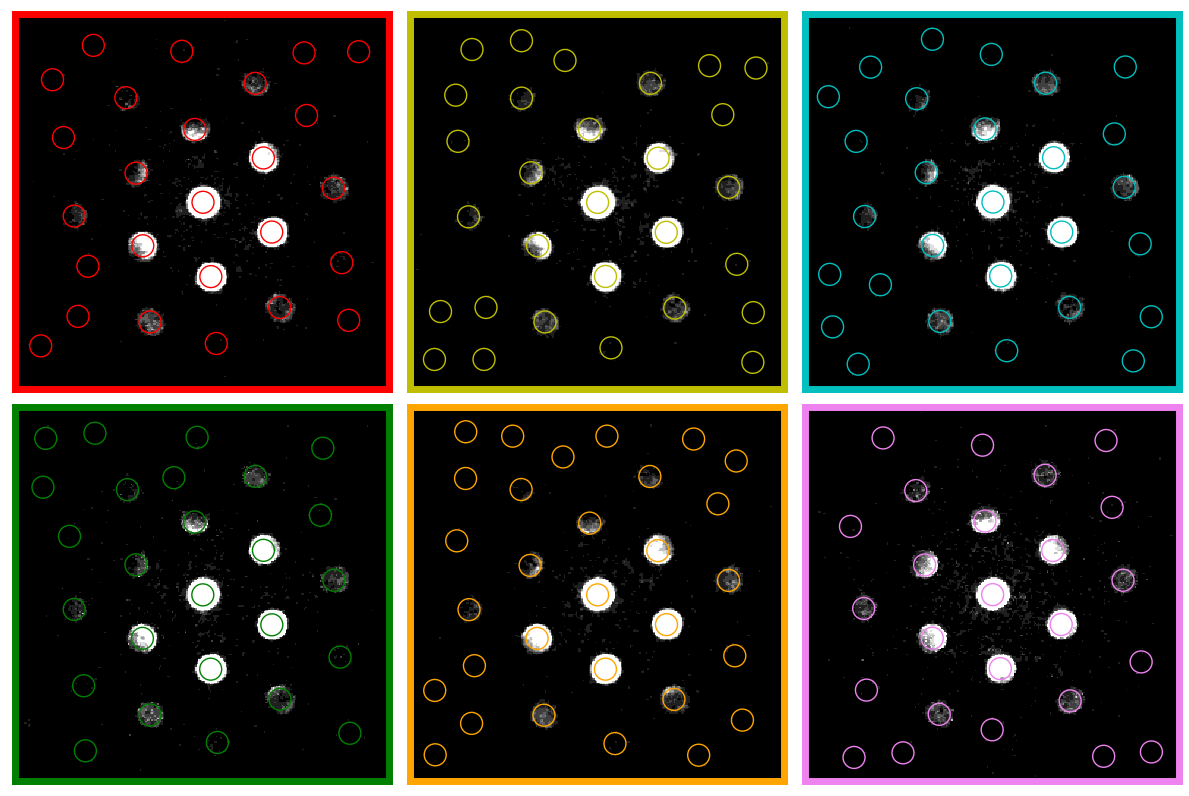

In [11]:
## Test hyperparameters on a few probe positions
colors=['r','y','c','g','orange','violet']

dp0 = dataset_cbed.data[rxs[0],rys[0],:,:]
dp1 = dataset_cbed.data[rxs[1],rys[1],:,:]
dp2 = dataset_cbed.data[rxs[2],rys[2],:,:]
dp3 = dataset_cbed.data[rxs[3],rys[3],:,:]
dp4 = dataset_cbed.data[rxs[4],rys[4],:,:]
dp5 = dataset_cbed.data[rxs[5],rys[5],:,:]

# Tune disk detection parameters on selected DPs
corrPower=1
sigma=0
edgeBoundary=16
minAbsoluteIntensity=100
minRelativeIntensity=0.0
minPeakSpacing=32
maxNumPeaks=100
subpixel='multicorr'
upsample_factor=16

disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset_cbed,
    probe_kernel,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

fig, ax = py4DSTEM.visualize.show_image_grid(
    lambda i:[dp0,dp1,dp2,dp3,dp4, dp5][i],H=2,W=3,
    axsize=(4,4),
    clipvals='manual',
    min=0.0000002,
    max=8,
    get_bordercolor=lambda i:colors[i],                    
    get_x=lambda i:disks_selected[i].data['qx'],
    get_y=lambda i:disks_selected[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    open_circles=True,scale=250,
    returnfig= True)
#fig.savefig('./paper_figs/exp_thin_DP.pdf', dpi=600)
plt.show()

In [12]:
# Find all Bragg peaks
# WARNING - this is the "slow" step, though it will only take ~1 minute for a dataset of this size.
# Note the speed depends strongly on whether 'multicorr' (more accurate) or 'poly' (faster) is used.

bragg_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=dataset_cbed,
    probe=probe_kernel,                 
    corrPower=corrPower,                       
    sigma=sigma,                 
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,    
    upsample_factor=upsample_factor,
    CUDA =True
)

Finding Bragg Disks: 100%|██████████| 12.1k/12.1k [04:03<00:00, 49.8DP/s]

Analyzed 12096 diffraction patterns in 0h 4m 3s


# Fit a lattice

In [13]:
# Center the Bragg disk positions about the origin
bragg_peaks_centered = py4DSTEM.process.calibration.center_braggpeaks(
    bragg_peaks,
    qx0=qx0,
    qy0=qy0)

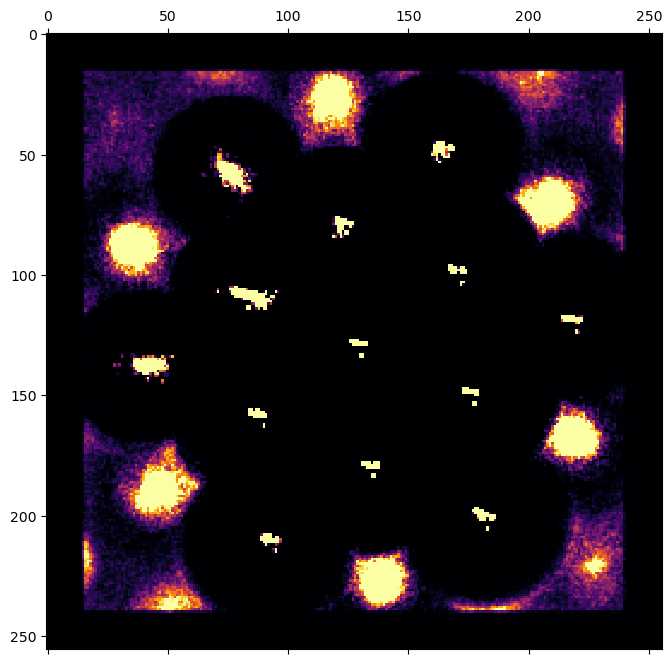

In [14]:
# Compute and plot Bragg vector map (BVM).

# Compute the Bragg vector map
bragg_vector_map = py4DSTEM.process.diskdetection.get_bvm(
    bragg_peaks_centered,
    256,
    256)

# plot the Bragg vector map
py4DSTEM.visualize.show(
    bragg_vector_map,
    cmap='inferno',
    clipvals='manual',
    min=0,
    max=1e-1)

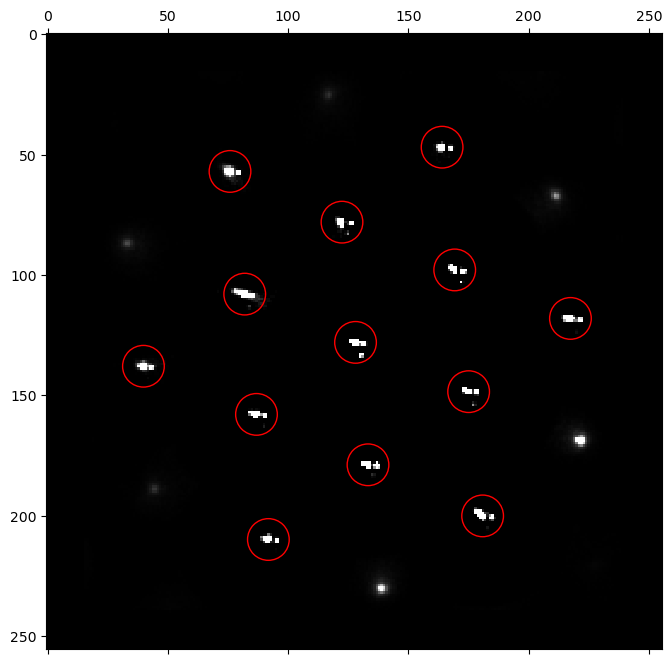

In [15]:
# Get all local maximum from the BVM, plot the candidate peaks
gx, gy, gI = py4DSTEM.process.utils.get_maxima_2D(
    bragg_vector_map,
    sigma=0, 
    edgeBoundary=10,
    minSpacing=16,
    minRelativeIntensity=0.001,
    relativeToPeak=0,
    maxNumPeaks=100,
    subpixel='multicorr'
)

# Plot the candidate lattice coordinates
py4DSTEM.visualize.show_points(
    bragg_vector_map,
    x=gx,
    y=gy,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=10,
    open_circles=True,
    scale=900)

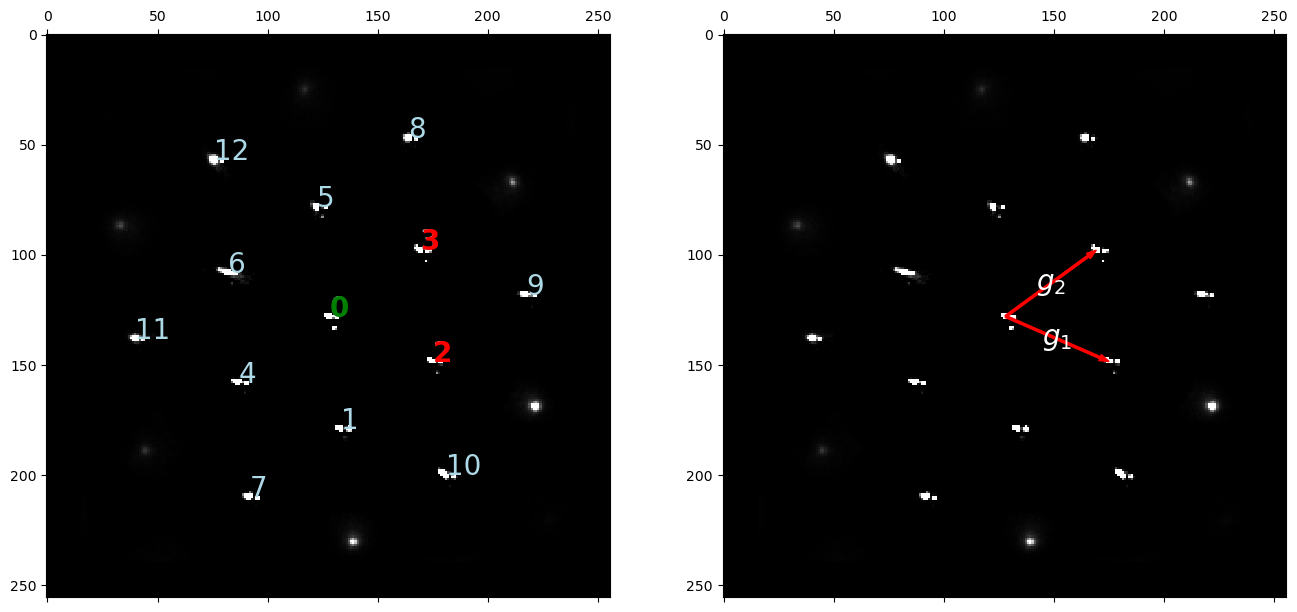

In [23]:
# Define peaks to use for computingstrain maps
index_0, index_g1, index_g2 = 0,2, 3

# Plot the selected lattice vectors - note they are in order of detected intensity
g1,g2 = py4DSTEM.visualize.select_lattice_vectors(
    bragg_vector_map,    
    figsize=(16,8),
    clipvals='manual',
    min=0,
    max=10,
    gx=gx,gy=gy,
    i0=index_0,
    i1=index_g1,
    i2=index_g2)

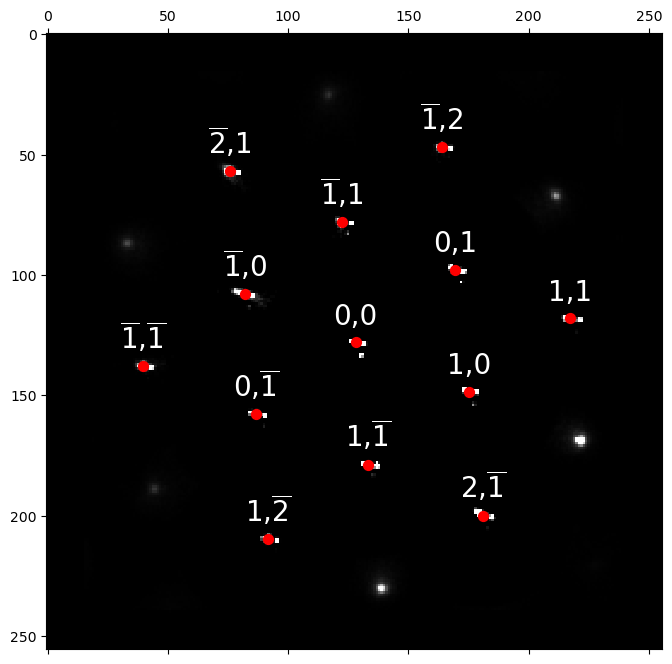

In [24]:
# Get indexing for all peaks, plot the indices overlaid onto the peaks
h, k, braggdirections = py4DSTEM.process.latticevectors.index_bragg_directions(
    qx0.mean(),qy0.mean(),
    gx,gy,
    g1,g2)
py4DSTEM.visualize.show_bragg_indexing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=10,
    braggdirections=braggdirections,
    points=True)

In [25]:
# maximum peak spacing from expected positions
max_peak_spacing = 8

# Add indices to the bragg_peaks PointListArray
bragg_peaks_indexed = py4DSTEM.process.latticevectors.add_indices_to_braggpeaks(
    bragg_peaks_centered,
    braggdirections,
    maxPeakSpacing=max_peak_spacing,
    qx_shift=qx0.mean(),
    qy_shift=qy0.mean())

In [26]:
# Fit the lattice in all diffraction images
g1g2_map = py4DSTEM.process.latticevectors.fit_lattice_vectors_all_DPs(bragg_peaks_indexed)

100%|██████████| 12096/12096 [00:01<00:00, 6402.27it/s]


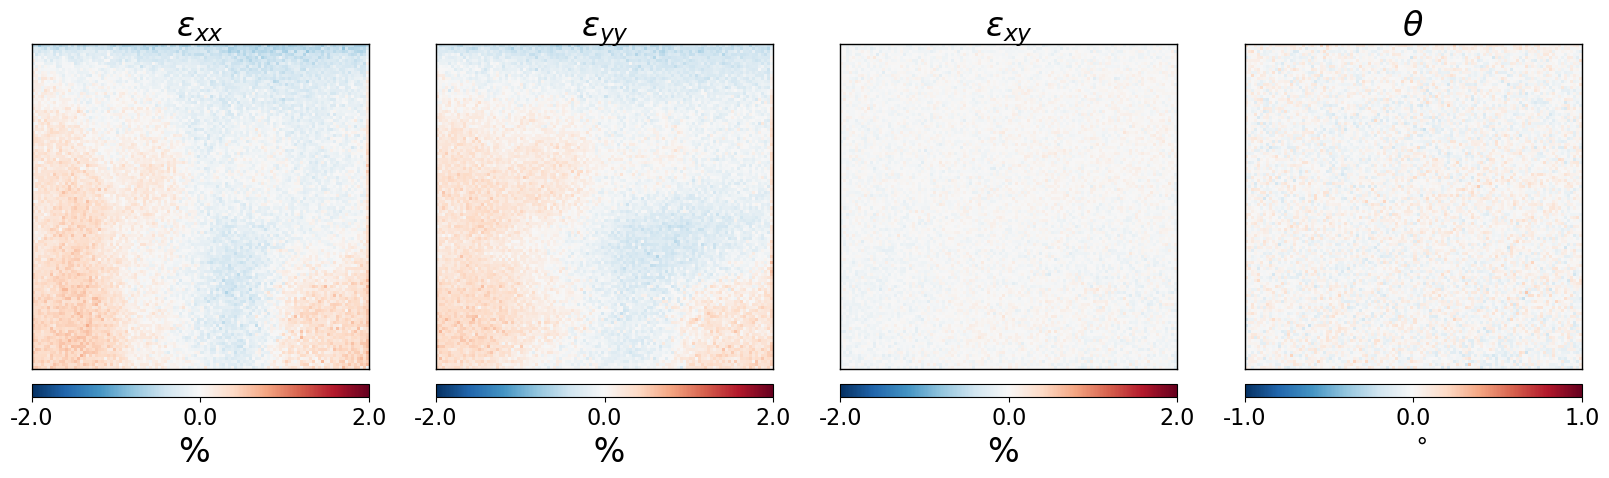

In [27]:
# Compute the strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset_cbed.R_Nx,dataset_cbed.R_Ny),dtype=bool))

# Rotate the lattice direction of the strain map 
# (pattern is rotated with respect to the scan direction)
g_reference = np.add(g1, g2)
#g_reference = g2
strainmap = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_mediang1g2,
    g_reference[0],
    g_reference[1])

mask = strainmap_mediang1g2.slices['mask'] == 1

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap,
    vrange_exx=[-2.0, 2.0],
    vrange_theta=[-1.0, 1.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(20,6),
    returnfig=True,
    layout=1,
)
#fig.savefig('./paper_figs/aiml_hBN_3.4mrad_BE_cropped_noref.pdf', dpi=600)
plt.show()

In [29]:
g1_ref = np.asarray([20.64417558165399, 47.44934944683895])
g2_ref = np.asarray([-30.60688129330852, 42.01223411415375])

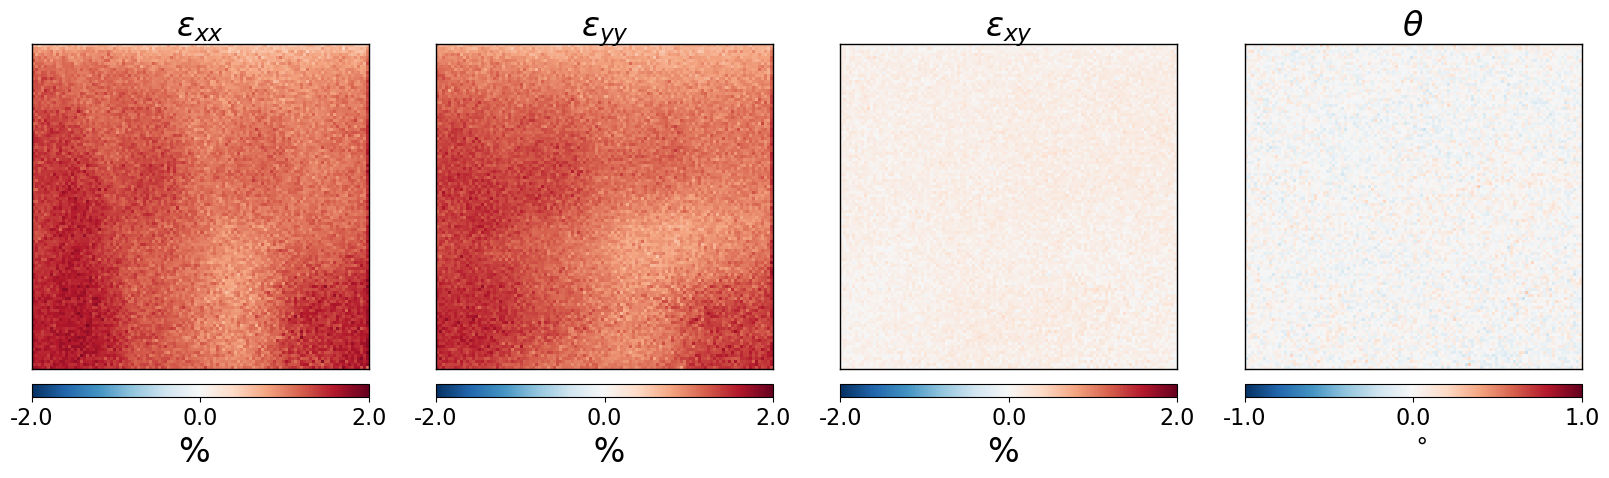

In [32]:
# Calculate the strain maps using the manual reference lattice
g_reference = np.add(g1_ref, g2_ref)

strainmap_raw = py4DSTEM.process.latticevectors.get_strain_from_reference_g1g2(
    g1g2_map,
    g1_ref,
    g2_ref)

# Rotate the lattice direction of the strain map 
strainmap_ROI = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_raw,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI,
    vrange_exx=[-2.0, 2.0],
    vrange_theta=[-1.0, 1.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(20,6),
    returnfig=True,
    layout=1,
)
#fig.savefig('./paper_figs/aiml_hBN_3.4mrad_BE_cropped_ref.pdf', dpi=600)
plt.show()

# Save data and strain maps

In [33]:
# Save all data in py4DSTEM format
# The diffraction space arrays we will save are:

diff = py4DSTEM.io.DiffractionSlice(
    data=np.dstack([diffraction_pattern_mean, 
                    probe_mean.data,
                    probe_kernel]),    
    slicelabels=['image_mean',
                 'probe',
                 'probe_kernel'],
    name='diffraction_images')

# The real space arrays we will save are:
real = py4DSTEM.io.RealSlice(
    data=np.dstack([image_BF, 
                    image_DF]),    
    slicelabels=['bright_field',
                 'dark_field'],
    name='real_space_images')

# Note we will also save the strain maps, but these are already stored as RealSlice objects.
# We will also store the center coordinates, estimated radius in pixels, strain reference direction,
# but most importantly - the Bragg disk positions and intensities (bragg_peaks_centered).
probe_fields = [("probe_semiangle",float),
              ("qx0", float),
              ("qy0", float)]
probe_data = py4DSTEM.io.PointList(coordinates=probe_fields)
probe_data.add_point((probe_semiangle, qx0, qy0))
probe_data.name = 'probe_data'

# Save all of the resulting data into a single .h5 file:
py4DSTEM.io.save(file_path_output,[diff,
                                      real,
                                      probe_data,
                                      strainmap_ROI,
                                      bragg_peaks_centered],
                                      overwrite=True)

  5%|▍         | 560/12096 [00:00<00:02, 5596.50it/s]

Saving DiffractionSlice 'diffraction_images'...
Saving RealSlice 'real_space_images'...
Saving PointList 'probe_data'...
Saving RealSlice 'strain_map_rotated'...
Saving PointListArray 'braggpeaks_centered'...


100%|██████████| 12096/12096 [00:01<00:00, 6319.33it/s]
